# Machine Learning Modeling Phase
In this notebook I'm running the machine learning modeling phase on the **Uber Fare Prices Dataset**. This dataset is available on a <a href="https://www.kaggle.com/datasets/yasserh/uber-fares-dataset" target="blank">Kaggle</a>. In this dataset, there are more than 200K observations with a total of 9 columns.

<img src="https://i.ibb.co/X7M4SK5/Screenshot-from-2022-07-01-10-12-49.png" width=900 />

The columns on the dataset are:
+ **key**                 -> an unique identifier for each trip (useless for modeling)
+ **fare_amout**          -> the cost of each trip in USD (target variable)
+ **pickup_datetime**     -> the precime datetime when the passenger was picked up
+ **passenger_count**     -> the quantity of passengers
+ **pickup_longitude**    -> the longitude where the trip began
+ **pickup_latitude**     -> the latitude where the trip began
+ **dropoff_longitude**   -> the longitude where the trip ended
+ **dropoff_latitude**    -> the latitude where the trip ended

***
This project is meant to be part of my personal portfolio.

**Author**: Arthur G.

## Importing Dependencies
Here I'm importing all the dependencies for this notebook.

In [1]:
# libs
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.regression import *

# settings
seed = np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)
warnings.filterwarnings('ignore')

## Loading Data
Now I'll load the processed dataset.

In [2]:
df = pd.read_csv(os.path.join('..', 'data', 'processed', 'processed_uber_trip_tax_data.csv'))

# applying log transformation on the target variable
df.fare_amount = np.log(df.fare_amount)

df.head()

,pickup_year,pickup_month,pickup_dayofyear,pickup_dayofweek,pickup_hour,is_holiday,passenger_count,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance_km,fare_amount
0,2015,5,127,3,19,0,1,40.738,-74.000,40.723,-74.000,1.683,2.015
1,2009,7,198,4,20,0,1,40.728,-73.994,40.750,-73.995,2.458,2.041
2,2009,8,236,0,21,0,1,40.741,-74.005,40.773,-73.963,5.036,2.557
3,2009,6,177,4,8,0,3,40.791,-73.976,40.803,-73.965,1.662,1.668
4,2014,8,240,3,17,0,5,40.744,-73.925,40.761,-73.973,4.475,2.773


## Regression Experiment
Now I'll be using PyCaret to setup the regression experiment. PyCaret is an abstraction of Scikit-learn in conjunction with other technologies.

In [3]:
reg_exp = setup(
    data=df,
    target='fare_amount',
    train_size=0.8,
    categorical_features=['pickup_year', 'pickup_dayofweek', 'is_holiday'],
    numeric_features=['pickup_month', 'pickup_dayofyear', 'pickup_hour', 
                      'passenger_count', 'pickup_latitude', 'pickup_longitude',
                      'dropoff_latitude', 'dropoff_longitude', 'trip_distance_km'],
    normalize=True,
    ignore_low_variance=True,
    use_gpu=False
)

,Description,Value
0,session_id,7692
1,Target,fare_amount
2,Original Data,"(196213, 13)"
3,Missing Values,True
4,Numeric Features,9
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(156958, 22)"


### Models Comparison
Let's train several models and compare their performance to pick up the best one.

In [4]:
best_model = compare_models(sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.1530,0.0612,0.2473,0.8303,0.0782,0.0759,0.5230
lightgbm,Light Gradient Boosting Machine,0.1613,0.0632,0.2513,0.8248,0.0794,0.0798,0.3990
catboost,CatBoost Regressor,0.1595,0.0659,0.2567,0.8172,0.0807,0.0790,3.4380
rf,Random Forest Regressor,0.1685,0.0683,0.2612,0.8108,0.0823,0.0832,4.3160
gbr,Gradient Boosting Regressor,0.1737,0.0688,0.2622,0.8093,0.0827,0.0857,29.8290
et,Extra Trees Regressor,0.1740,0.0711,0.2666,0.8029,0.0841,0.0862,11.7530
dt,Decision Tree Regressor,0.2357,0.1324,0.3639,0.6328,0.1149,0.1163,2.1140
lar,Least Angle Regression,0.4588,0.3524,0.5936,0.0230,0.1784,0.2199,0.0750
br,Bayesian Ridge,0.4588,0.3524,0.5936,0.0231,0.1784,0.2199,0.2180
ridge,Ridge Regression,0.4588,0.3524,0.5936,0.0230,0.1784,0.2199,0.0220


In [4]:
best_model = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1525,0.0601,0.2452,0.8293,0.0780,0.0760
1,0.1503,0.0542,0.2329,0.8466,0.0756,0.0755
2,0.1540,0.0598,0.2446,0.8356,0.0780,0.0767
3,0.1524,0.0589,0.2428,0.8329,0.0774,0.0754
4,0.1554,0.0630,0.2510,0.8249,0.0791,0.0771
5,0.1539,0.0616,0.2481,0.8308,0.0787,0.0762
6,0.1565,0.0638,0.2526,0.8213,0.0798,0.0771
7,0.1550,0.0626,0.2501,0.8320,0.0777,0.0766
8,0.1547,0.0591,0.2431,0.8355,0.0780,0.0774


### Model Tuning
The performance of the base model is too good for a bayesian optimization process, which is time consuming, so let's jump straight into the model interpretation and validation phases.

### Model Plot
Now it's time to plot some model's performance indicators calculated during the training phase. Let's start with the error plot.

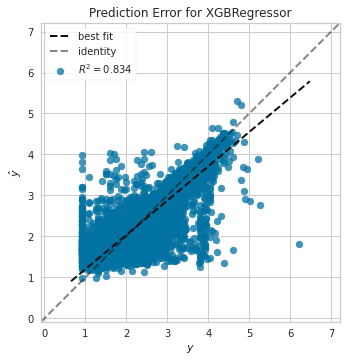

In [6]:
_ = plot_model(best_model, plot = 'error')

It seems that we have some outliers causing some side effects but nothing too much serious for now. Let's look at the features importance using our base model.

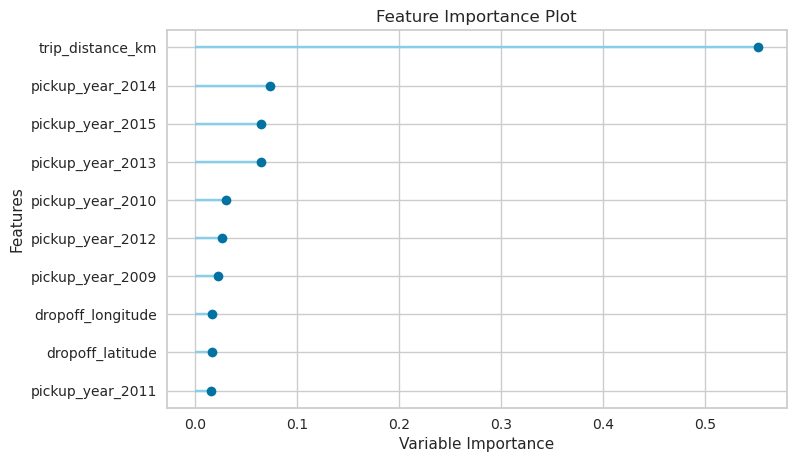

In [7]:
_ = plot_model(best_model, plot = 'feature')

The distance calculated with the heversin formula is, as we could expect, the most important feature. Now let's see the optimized parameters of our trained model.

In [8]:
plot_model(best_model, plot = 'parameter')

,Parameters
objective,reg:squarederror
base_score,0.5
booster,gbtree
colsample_bylevel,1
colsample_bynode,1
colsample_bytree,1
enable_categorical,False
gamma,0
gpu_id,0
importance_type,None


### Model Interpretation
Let's use our trained model to interpret it's results and understand what leads to the predictions the way they're made.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


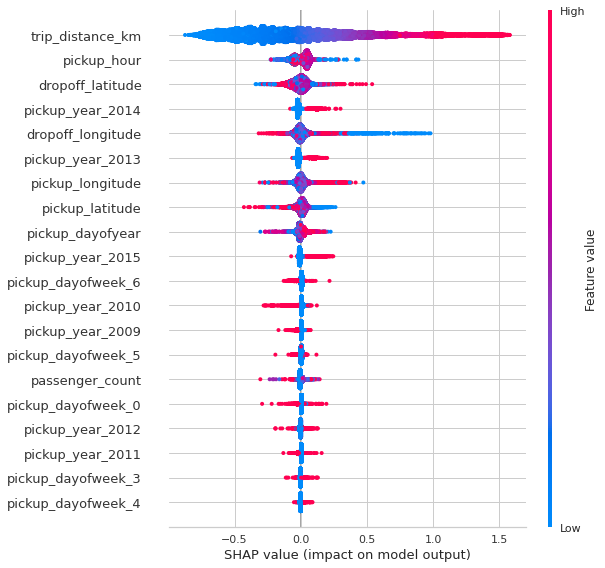

In [9]:
_ = interpret_model(best_model, plot='summary')

As we expected, the highest **trip_distance_km** is, then higher is the fare price.

### Model Validation
Now let's use the holdout data for model validation.

In [5]:
preds = predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.1536,0.0628,0.2505,0.8293,0.0792,0.0764


The performance of our model on the validation set is almost the same as the performance during training, which is a good sign. The low RMSE rate, as well as the MAPE rate are good indicators of the high performance of the trained model.

### Finalizing the Model
The model finalization step is where we train the best model with all the data available, before serializing the algorithm.

In [7]:
finalized_regressor = finalize_model(best_model)

### Model Serialization
We can finally serialize the model to a file.

In [10]:
save_model(finalized_regressor, os.path.join('..', 'models', 'xgb_regressor'))

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['pickup_year',
                                                             'pickup_dayofweek',
                                                             'is_holiday'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['pickup_month',
                                                           'pickup_dayofyear',
                                                           'pickup_hour',
                                                           'passenger_count',
                                                           'pickup_latitude',
                                                           'pickup_longitude',
                                                           'dropoff_latitude',
                